# Feature importance

On va faire un modèle qui contient toutes les données en notre possession et voir a posteriori les données qui ont le plus influencé le modèle. 

## Dataframe global

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# librairies perso
from make_train_test_set import make_train_test_set
from import_data import import_data
from metrics import metrics 
from group_by_clients import group_by_clients

In [2]:
data = pd.read_csv("../data/dataset_modify").drop("Unnamed: 0", axis = 1)
data["horodate"] = pd.to_datetime(data["horodate"])

In [3]:
# on ajoute les données du CAC aux dataframe global
cac = pd.read_csv("../data/^FCHI.csv")
cac["horodate"] = pd.to_datetime(cac["Date"])
cac = cac.drop(["High", "Low", "Date", "Close", "Adj Close", "Volume"], axis = 1)
cac = cac[cac["horodate"] <= pd.to_datetime("2023-01-31")]
data = pd.merge(data, cac, on = ["horodate"], how = "left").sort_values(["id_client", "horodate"]).dropna()
data.rename({"Open": "CAC"}, axis = 1, inplace = True)

In [4]:
# on ajoute les données du gaz 
gas = pd.read_csv("../data/gas.csv")
gas["horodate"] = pd.to_datetime(gas["horodate"])
gas["horodate"] = gas["horodate"] + pd.Timedelta(days = 14)
gas = gas[(gas["horodate"] <= pd.to_datetime("2023-01-31")) & (gas["horodate"] >= pd.to_datetime("2021-01-01"))]
data = pd.merge(data, gas, on = ["horodate"], how = "left").sort_values(["id_client", "horodate"]).dropna()

In [5]:
# on ajoute la météo 
meteo = pd.read_csv("../data/brussels 2021-01-01 to 2023-04-01.csv").rename({"datetime": "horodate"}, axis = 1)
meteo = meteo[["horodate", "temp"]]
meteo["horodate"] = pd.to_datetime(meteo["horodate"])
data = pd.merge(data, meteo, on = ["horodate"], how = "left").sort_values(["id_client", "horodate"]).dropna()

## Création des données d'entrainement

In [6]:
clients = group_by_clients(data)
n = len(clients)

In [7]:
X_train, X_test, y_train, y_test, test_data = make_train_test_set(clients, ["id_client", "jour", "forecasted_consumption", "CAC", "Gas Price", "temp"], ["real_consumption"])

## Création des modèles

In [8]:
models = [LinearRegression() for _ in range(n)]
for i, model in enumerate(models): 
    model.fit(X_train[i], y_train[i])

In [9]:
y_pred = []
for i, model in enumerate(models) : 
    y_pred.append(model.predict(X_test[i]).reshape(len(X_test[i])))

## Evaluation du modèle

In [10]:
evaluation_model = []
evalutation_airliquide_model = []
for i in range(n): 
    evaluation_model.append(metrics(test_data[i]["real_consumption"], y_pred[i]))
    evalutation_airliquide_model.append(metrics(test_data[i]["real_consumption"], test_data[i]["prediction"]))

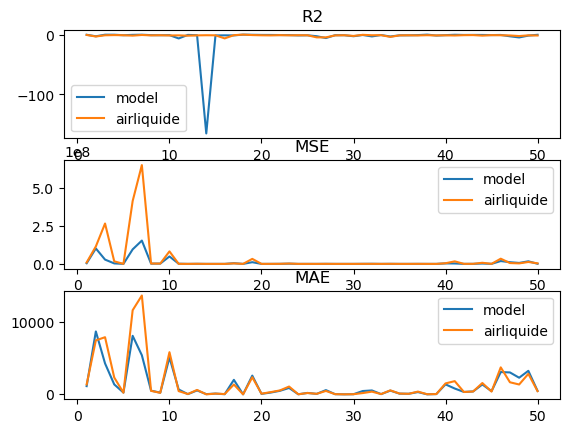

In [11]:
X = list(range(1,n+1))
fig, ax = plt.subplots(3)
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(3): 
    ax[i].plot(X, [x[i] for x in evaluation_model], label = "model")
    ax[i].plot(X, [x[i] for x in evalutation_airliquide_model], label = "airliquide")
    ax[i].legend()

## Feature importance

In [12]:
def display_feat_imp(models):
    k = len(models)
    feat_imp_reg = 0
    for model in models: 
        feat_imp_reg += model.coef_[0]
    feat_imp_reg /= k
    feat_importance = pd.DataFrame(columns = ["Feature Name", "Feature Importance"])
    feat_importance["Feature Name"] = pd.Series(model.feature_names_in_)
    feat_importance["Feature Importance"] = pd.Series(feat_imp_reg)
    feat_importance.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")

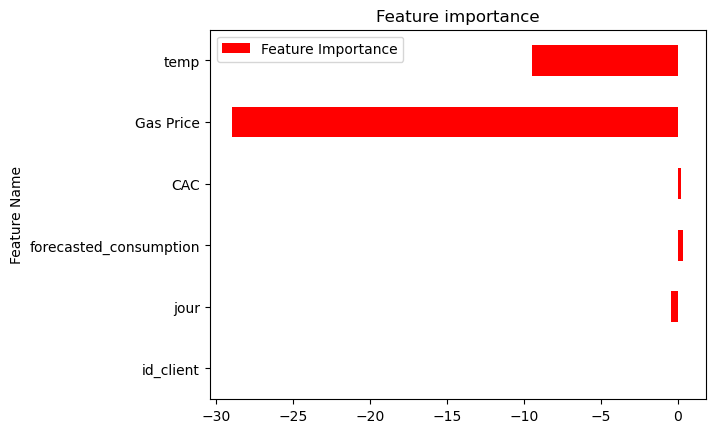

In [13]:
display_feat_imp(models)

On en déduit qu'on peut enlever gas price et temp. 

# Deuxième essai sans ces variables

In [14]:
X_train, X_test, y_train, y_test, test_data = make_train_test_set(clients, ["id_client", "jour", "forecasted_consumption", "CAC"], ["real_consumption"])

In [15]:
models_v2 = [LinearRegression() for _ in range(n)]
for i, model in enumerate(models_v2): 
    model.fit(X_train[i], y_train[i])

In [16]:
y_pred = []
for i, model in enumerate(models_v2) : 
    y_pred.append(model.predict(X_test[i]).reshape(len(X_test[i])))

### Evaluation du modèle

In [17]:
evaluation_model_v2 = []
evalutation_airliquide_model = []
for i in range(n): 
    evaluation_model_v2.append(metrics(test_data[i]["real_consumption"], y_pred[i]))
    evalutation_airliquide_model.append(metrics(test_data[i]["real_consumption"], test_data[i]["prediction"]))

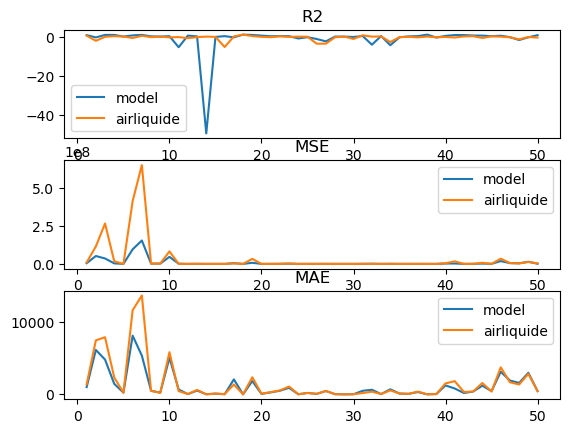

In [18]:
X = list(range(1,n+1))
fig, ax = plt.subplots(3)
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(3): 
    ax[i].plot(X, [x[i] for x in evaluation_model_v2], label = "model")
    ax[i].plot(X, [x[i] for x in evalutation_airliquide_model], label = "airliquide")
    ax[i].legend()

### Feature importance

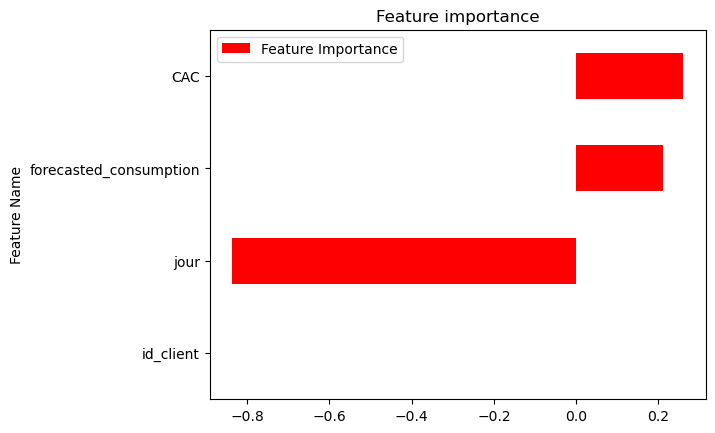

In [19]:
display_feat_imp(models_v2)